# IASA DS CHAMP
## EDA
### first look on data

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor



In [106]:
df = pd.read_csv("IASA.csv")

In [107]:
print("\033[1mDimensions:\033[0m", df.shape)
print("\033[1mData types:\033[0m")
print(df.dtypes.value_counts())
pd.set_option('display.max_columns', None)
df.head()

Dimensions: (1467832, 63)
Data types:
int64      42
float64    17
object      4
dtype: int64


total_sessions_day0  total_sessions_day1  total_sessions_day3  \
0                  1.0                  1.0                  1.0   
1                  1.0                  1.0                  1.0   
2                  1.0                  2.0                  2.0   
3                  1.0                  1.0                  1.0   
4                  1.0                  1.0                  1.0   

   total_sessions_day7  chapters_finished_day0  chapters_finished_day1  \
0                  1.0                       0                       0   
1                  1.0                       0                       0   
2                  2.0                       0                       0   
3                  1.0                       0                       0   
4                  1.0                       0                       0   

   chapters_finished_day3  chapters_finished_day7  chapters_opened_day0  \
0                       0                       0                     0   
1                       0                       0                     0   
2                       0                       0                     0   
3                       0                       0                     0   
4                       0                       0                     0   

   chapters_opened_day1  chapters_opened_day3  chapters_opened_day7  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   chapters_closed_day0  chapters_closed_day1  chapters_closed_day3  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   chapters_closed_day7  diamonds_received_day0  diamonds_received_day1  \
0                     0                       0                       0   
1                     0                       0                       0   
2                     0                       0                       0   
3                     0                       0                       0   
4                     0                       0                       0   

   diamonds_received_day3  diamonds_received_day7  diamonds_spent_day0  \
0                       0                       0                    0   
1                       0                       0                    0   
2                       0                       0                    0   
3                       0                       0                    0   
4                       0                       0                    0   

   diamonds_spent_day1  diamonds_spent_day3  diamonds_spent_day7  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   tickets_spent_day0  tickets_spent_day1  tickets_spent_day3  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   tickets_spent_day7  retained_day1  retained_day3  retained_day7  \
0                   0              0              0              0   
1       

<b> Categorical features: </b>

In [108]:
df.describe(include=['object'])

media_source install_date country_code platform
count       1467832      1467832      1467832  1467832
unique           24           62          224        2
top        SOURCE_4   2021-12-30  COUNTRY_141  android
freq         728958        94101       387761   887426

<b> Target distribution: </b>

In [109]:
df['target_full_ltv_day30'].describe()  # shows presence of negative targets

count    1.467832e+06
mean     2.568728e-01
std      2.274466e+00
min     -2.777195e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.720042e+02
Name: target_full_ltv_day30, dtype: float64

In [110]:
df = df[df['target_full_ltv_day30'] >= 0]

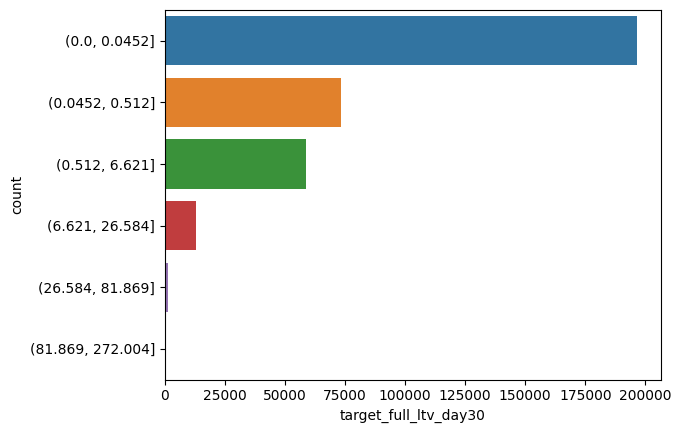

In [111]:
bins=[df.target_full_ltv_day30.min(),0.04522636803715195,0.5122277383568737,6.620577148714897,26.58414246846844,81.86909682893791,df.target_full_ltv_day30.max()]
df['count']=pd.cut(df.target_full_ltv_day30,bins)
sns.barplot(data=df.groupby('count')['target_full_ltv_day30'].count().reset_index(),y='count',x='target_full_ltv_day30')
df = df.drop('count', axis=1)

### Preprocessing
We plan to train 3 XGBoost models to predict all three parts of our target - 'target_sub_ltv_day30', 'target_iap_ltv_day30' and 'target_ad_ltv_day30', and then sum the predictions. This will allow us to separately train three different models, each of which will solve its own problem.
XGBoost is chosen because its good performance (compared to other models) and incredible speed (if training on a GPU) give great performance/speed trade-off which allows to iterate faster and re-train in case of data change. Also, it doesn't care about outliers.

Install date wouldn't provide any useful data to our models, so we'll drop it.
Other categorical features have more potential, so we'll use one-hot encoding for them.

In [112]:
df.dropna(inplace=True)  # There are only 1374 NaNs, so we can safely drop them without sacrificing a lot of data
df.drop('install_date', axis=1, inplace=True)
df = pd.get_dummies(df, columns=['country_code', 'media_source', 'platform'])

### Train/test split

In [113]:
y = df['target_full_ltv_day30']   # Saving the original target
df = df.drop('target_full_ltv_day30', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.1, random_state=42)

y_sub_train, y_sub_valid = X_train['target_sub_ltv_day30'], X_valid['target_sub_ltv_day30']
y_iap_train, y_iap_valid = X_train['target_iap_ltv_day30'], X_valid['target_iap_ltv_day30']
y_ad_train, y_ad_valid = X_train['target_ad_ltv_day30'], X_valid['target_ad_ltv_day30']

X_train = X_train.drop(['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30'], axis=1)
X_valid = X_valid.drop(['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30'], axis=1)

## Models and training
All models will be trained using RMSE metrics, which is default for them. We chose it as the main one because it is stricter in case of large mistakes and long datasets.
We already did some parameter tuning to fit each model better to their targets, or, in some cases, reduce overfitting.

In [114]:
XGB_sub = XGBRegressor(tree_method='gpu_hist', learning_rate=0.15, max_depth=9, reg_alpha=17.3, random_state=42)
XGB_sub.fit(X_train, y_sub_train)

XGB_iap = XGBRegressor(tree_method='gpu_hist', learning_rate=0.15, reg_alpha=9.14, random_state=42)
XGB_iap.fit(X_train, y_iap_train)

XGB_ad = XGBRegressor(tree_method='gpu_hist', learning_rate=0.15, max_depth=5, reg_alpha=6.43, random_state=42)
XGB_ad.fit(X_train, y_ad_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=6.43, reg_lambda=1, ...)

Saving the models and data for testing...

In [115]:
XGB_sub.save_model("XGB_sub.json")
XGB_iap.save_model("XGB_iap.json")
XGB_ad.save_model("XGB_ad.json")

(X_train.iloc[np.where(y_train > 50)[0]]).to_csv("X_train_high.csv", index=False)
X_valid.to_csv("X_valid.csv", index=False)
y_sub_valid.to_csv("y_sub_valid.csv", index=False)
y_iap_valid.to_csv("y_iap_valid.csv", index=False)
y_ad_valid.to_csv("y_ad_valid.csv", index=False)
y_valid.to_csv("y_valid.csv", index=False)